In [3]:
from legwork import evol, utils
import legwork.strain as strain
import legwork

import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
import scipy.special as sp
from scipy.integrate import solve_ivp

from astropy.constants import G
from astropy.constants import c

from scipy.integrate import quad
from scipy.special import gamma

from joblib import Parallel, delayed
import os

## Initial Condition

In [4]:
m_1 = 40 * u.Msun
m_2 =  4.3*10**6 * u.Msun
mu = m_1 * m_2 / (m_1 + m_2)
M = m_1 + m_2
m_c = utils.chirp_mass(m_1, m_2)

ecc_i = 0.9995
a_i = 0.01 * u.pc
f_orb_i = utils.get_f_orb_from_a(a =a_i, m_1=m_1, m_2=m_2)

dist = 8 * u.kpc
t_obs = 1 * u.yr

# calculate other params
beta = utils.beta(m_1=m_1, m_2=m_2)
c_0 = utils.c_0(a_i, ecc_i)

t_merge = evol.get_t_merge_ecc(ecc_i, a_i=a_i, f_orb_i=f_orb_i, beta=beta, m_1=m_1, m_2=m_2, small_e_tol=0.001, large_e_tol=0.99999, exact=True)
t_merge = t_merge.to(u.yr)


(<Quantity 9.1378137e+33 m4 / s>, <Quantity 0.01 pc>)

## Time derivative of a and e

In [5]:
def da_dt_gw(a, e):

    mu = (m_1 * m_2 / (m_1 + m_2)).to(u.kg)  
    M = (m_1 + m_2).to(u.kg)  
    a = a.to(u.m)

    factor1 = - (64 / 5) * (G**3 * mu * M**2) / (c**5 * a**3)
    factor2 = 1 / (1 - e**2)**(7/2)
    factor3 = 1 + (73/24) * e**2 + (37/96) * e**4
    return factor1 * factor2 * factor3

def de_dt_gw(a, e):

    mu = (m_1 * m_2 / (m_1 + m_2)).to(u.kg)  
    M = (m_1 + m_2).to(u.kg)  
    a = a.to(u.m)
    
    factor1 = - (304 / 15) * (G**3 * mu * M**2) / (c**5 * a**4)
    factor2 = e / (1 - e**2)**(5/2)
    factor3 = 1 + (121/304) * e**2
    return factor1 * factor2 * factor3

## Orbit evolution

In [6]:
def orbital_evolution(t, y):
    a, e = y
    a = a * u.pc  
    da = da_dt_gw(a.to(u.m), e,).to(u.pc / u.yr).value  
    de = de_dt_gw(a.to(u.m), e).to(1 / u.yr).value 
    return [da, de]


def event_e_zero(t, y):
    a, e = y
    return e - 0.001  


event_e_zero.terminal = True
event_e_zero.direction = -1  


y0 = [a_i.to(u.pc).value, ecc_i] 
t_span = (0, 1e30)  


solution = solve_ivp(
    orbital_evolution, 
    t_span, 
    y0, 
    method='LSODA', 
    dense_output=True,  
    events=event_e_zero,  
    rtol=1e-4, 
    atol=1e-8
)
t_event = solution.t[-1]  # 获取第一个触发事件的时间
print(f"停止时的时间 t_event = {t_event} 年")

停止时的时间 t_event = 453273.39307265513 年


### orbit data save

In [7]:
def query_a_e_at_time(t_query):
    """查询指定时间点 t_query 的 a 和 e 值"""
    a, e = solution.sol(t_query)  # solution.sol 返回 a 和 e 的插值
    return a, e


import pandas as pd

# num_samples = round(t_event/10)  
# t_values = np.linspace(solution.t[0], solution.t[-1], num_samples)  
t0 = solution.t[0]
t1 = t_event - 100000
t2 = t_event - 10000       
t3 = t_event - 1000      
t4 = t_event - 100     
t5 = t_event        

t_values_0 = np.arange(t0, t1 + 1, 10000)
t_values_1 = np.arange(t1 + 1, t2 + 1, 1000)   
t_values_2 = np.arange(t2 + 1, t3 + 1, 100)  
t_values_3 = np.arange(t3 + 1, t4 + 1, 10)    
t_values_4 = np.arange(t4 + 1, t5 + 1, 1)       

t_values = np.unique(np.concatenate([t_values_0, t_values_1, t_values_2, t_values_3, t_values_4]))

a_values, e_values = solution.sol(t_values)  


# # weights = e_values / np.sum(e_values)  
# selected_indices = np.random.choice(range(num_samples), size=num_samples, replace=False) #p=weights)  


selected_t_values = t_values
selected_a_values = a_values
selected_e_values = e_values

f_orb_values = utils.get_f_orb_from_a(a =selected_a_values * u.pc, m_1=m_1, m_2=m_2).value 

a_after1yr , e_after1yr= query_a_e_at_time(selected_t_values+1)

delta_f_orb_values = utils.get_f_orb_from_a(a =a_after1yr* u.pc, m_1=m_1, m_2=m_2).value - f_orb_values


df_selected_moments = pd.DataFrame({
    'time': selected_t_values,
    'a (pc)': selected_a_values,
    'e': selected_e_values,
    'f_orb': f_orb_values,
    'delta_f_orb': delta_f_orb_values
})


print(df_selected_moments.head())


df_selected_moments.to_csv("data/selected_emri_moments40.csv", index=False)

      time   a (pc)         e         f_orb   delta_f_orb
0      0.0  0.01000  0.999500  7.014333e-10  4.660169e-15
1  10000.0  0.00956  0.999477  7.503624e-10  5.122446e-15
2  20000.0  0.00913  0.999452  8.040084e-10  5.616262e-15
3  30000.0  0.00871  0.999426  8.628901e-10  6.171005e-15
4  40000.0  0.00830  0.999397  9.276633e-10  6.796357e-15


d:\pyfile\legwork\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## SNR and a_band calculation

In [8]:
kwargs ={
    # 'f': f_orb,
    # 'L': "auto",
    # 't_obs': 1 * u.yr,
    # 'approximate_R': False,
    # 'confusion_noise': "auto"
    "instrument": "LISA",
    "confusion_noise": "auto"
        }

m_c_array = np.tile(m_c, len(e_values))
m_1_array = np.tile(m_1,len(e_values))
m_2_array = np.tile(m_2,len(e_values))
dist_array = np.tile(dist,len(e_values))
beta_array = np.tile(beta,len(e_values))

In [9]:
def compute_snr(m_c, f_orb, e):
    snr = legwork.snr.snr_ecc_stationary(
        np.array([m_c.si.value]) * u.kg,
        np.array([f_orb])* u.Hz,
        np.array([e]),
        dist,
        t_obs,
        10000,
        interpolated_g=None,
        interpolated_sc=None,
        ret_max_snr_harmonic=False,
        ret_snr2_by_harmonic=False,
        **kwargs
    )
    return snr

result = Parallel(n_jobs=-1)(
    delayed(compute_snr)(m_c, f_orb, e)
    for m_c, f_orb, e in zip(m_c_array, f_orb_values, e_values)
)

snr = np.concatenate(result)

snr_ = pd.DataFrame({
        't_merge':t_event-t_values,

        'snr':snr
})

snr_.to_csv('data/snr_40_gw.csv',index=False)

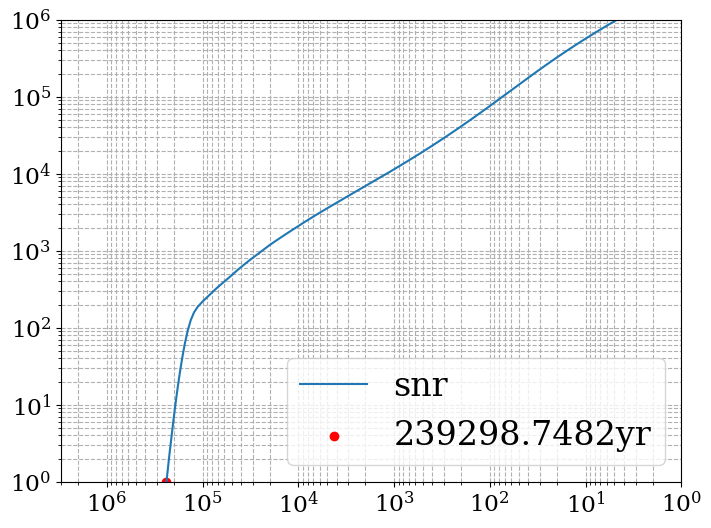

交点坐标: t = 239298.748247, snr = 1.000000


In [10]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
f1 = interp1d(t_event-t_values, snr, kind='cubic', fill_value="extrapolate")
f2 = interp1d(t_event-t_values, np.full(len(snr),1), kind='cubic', fill_value="extrapolate")

def func_diff(x_val):
    return f1(x_val) - f2(x_val)

initial_guess = 10**5


x_intersect = fsolve(func_diff, initial_guess)[0]
y_intersect = f1(x_intersect)


plt.figure(figsize=(8, 6))
plt.plot(t_event-t_values, snr, label="snr")
plt.scatter([x_intersect], [y_intersect], color='red', label=f"{x_intersect:.4f}yr")

plt.xscale('log')
plt.yscale('log')
plt.xlim( 3 * 10**(6), 10**(0))
plt.ylim(10**(0),10**6)
# plt.xlabel("1-e (log scale)")
# plt.ylabel("a (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"交点坐标: t = {x_intersect:.6f}, snr = {y_intersect:.6f}")

In [11]:
t = t_event - x_intersect
a_band, e_band = query_a_e_at_time(t)
print(f"a_band = {a_band}pc,e_band = {e_band} ")

a_band = 0.002794333435821961pc,e_band = 0.9981965637561944 


## a_thr calculation

In [12]:
n_max = 100
hc_array = np.zeros((len(e_values), n_max))


def compute_hc_row(i, n_max, m_c, f_orb_values, e_values, dist):
    hc_row = np.zeros(n_max)
    for n in range(1, n_max + 1):
        hc_row[n - 1] = strain.h_c_n(m_c=m_c, f_orb=f_orb_values[i], ecc=e_values[i], n=n, dist=dist).flatten()
    return i, hc_row

results = Parallel(n_jobs=-1)(
    delayed(compute_hc_row)(i, n_max, m_c, f_orb_values, e_values, dist) 
    for i in range(0, len(e_values))
)


for i, hc_row in results:
    hc_array[i] = hc_row


candidate_indices = []

for i in range(len(hc_array)):
    max_hc_n = np.argmax(hc_array[i]) + 1
    max_hc_value = np.max(hc_array[i])
    
    if max_hc_n == 2:
        candidate_indices.append(i)

if candidate_indices:
    min_i = min(candidate_indices)
    print(f"满足条件的最小 i 为 {min_i}, 对应的偏心率 e = {e_values[min_i]}")
else:
    print("没有找到满足条件的 i 值")

# 查询 a_thr 和 e_thr
a_thr, e_thr = query_a_e_at_time(t_values[min_i])

print(f"a_thr = {a_thr}pc,e_thr = {e_thr} ,t = {t_values[min_i]}")

满足条件的最小 i 为 265, 对应的偏心率 e = 0.35321617340397166
a_thr = 5.690780771056234e-06pc,e_thr = 0.35321617340397166 ,t = 452764.39307265513


In [13]:
a_thr, e_thr = query_a_e_at_time(t_values[min_i])

## a_min calculation

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

# 假设在多个时间点上，你得到了 a_vals 和 e_vals
# 这些值可以通过 solution.sol 在不同时间点计算获得
time_vals = np.linspace(0, t_event, 1000000)  # 时间点
a_vals = []
e_vals = []

for tt in time_vals:
    a, e = query_a_e_at_time(tt)  # 获取 (a, e) 对
    a_vals.append(a)
    e_vals.append(e)

# 创建反向插值函数
e_interp = interp1d(a_vals, e_vals, kind='linear', fill_value="extrapolate")
a_interp = interp1d(e_vals, a_vals, kind='linear', fill_value="extrapolate")

# 给定某个 a，推算对应的 e
e_at_given_a = e_interp(8*10**(-7))
a_e02 = a_interp(0.2)

## source number calculation

In [15]:
dt1 = t
dt2 = t_values[min_i] - t
dt3 = t_event - t_values[min_i]
print(f"在band之前度过的时间 = {dt1},进入band后轨道圆化之前度过的时间 = {dt2},圆化后到并合度过的时间 = {dt3}")

在band之前度过的时间 = 213974.64482533996,进入band后轨道圆化之前度过的时间 = 238789.74824731518,圆化后到并合度过的时间 = 509.0


In [17]:
N = 2e4
R_h = 1*u.pc
lam_0 = np.log(m_2/m_1) / 13
N_0 = N / 12000
R_0 = R_h / (1*u.pc)
m_1_0 = m_1/ (10*u.Msun)
C = 1
W = 0.27

a_thr1 = a_thr * u.pc
a_min1 = 8*10**(-7) * u.pc
a_band1 = a_band * u.pc
a_cri1 = a_i

gamm = 1.92*10**(-6) * (u.yr)**(-1) * N_0 * lam_0 * R_0**(-2) * m_1_0**2 *(0.16 * N_0**(-1/2) * lam_0**(-1/2) * R_0**(1/2) * m_1_0**(1/2) * W**(-5/4) *(np.log(9138 * N_0**(-1) * lam_0**(-1) * R_0 * m_1_0 * W**(-5/2)) - 2) - 4 * 10**(-2) * R_0**(1/2)  * (np.log(618 * R_0) - 2 ))
t_band = (t_event-t)  * u.yr

In [18]:
def da_dt_inverse(a):

    e = e_interp(a)
    s = da_dt_gw(a*u.pc,e).to(u.pc/u.yr)
    return 1/s.value

from scipy.integrate import quad

def number(a1, a2, a3, a4):

    factor, _ = quad(da_dt_inverse, a4, a2 , epsabs=1e-15, epsrel=1e-15)
    k = gamm * t_band / factor
    n1, err1 = quad(da_dt_inverse, a4, a3, epsabs=1e-15, epsrel=1e-15 ) * k
    n2,err2 = quad(da_dt_inverse, a3, a2 , epsabs=1e-15, epsrel=1e-15) * k
    n3, err3 = quad(da_dt_inverse, a2, a1 ) * k
    print(n1,n2,n3,k)
    arr = [n1,n2,n3]

    return arr

In [ ]:
arr = number(0.01, a_band, a_thr, a_e02)
arr

C:\Users\Fc_Tp\AppData\Local\Temp\ipykernel_22340\853378458.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  factor, _ = quad(da_dt_inverse, a4, a2 , epsabs=1e-15, epsrel=1e-15)
C:\Users\Fc_Tp\AppData\Local\Temp\ipykernel_22340\853378458.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  n1, err1 = quad(da_dt_inverse, a4, a3, epsabs=1e-15, epsrel=1e-15 ) * k


0.3526456352898968 165.4072819824262 nan -0.0006926377404241064


C:\Users\Fc_Tp\AppData\Local\Temp\ipykernel_22340\853378458.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  n2,err2 = quad(da_dt_inverse, a3, a2 , epsabs=1e-15, epsrel=1e-15) * k
C:\Users\Fc_Tp\AppData\Local\Temp\ipykernel_22340\2288360971.py:8: RuntimeWarning: invalid value encountered in scalar power
  factor2 = 1 / (1 - e**2)**(7/2)
C:\Users\Fc_Tp\AppData\Local\Temp\ipykernel_22340\853378458.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  n3, err3 

[<Quantity 0.35264564>, <Quantity 165.40728198>, <Quantity nan>]